# 4. Pastastore

In this notebook you will learn:
- what a pastastore is (within the context of the Pastas Python package).
- how observations series, stresses and models are stored in a pastastore.
- how to do bulk operations on pastastores.
- how to write and read a pastastores from a file.


In order to do bulk operations on time series models you can use a Pastastore. A Pastastore is an object that can contain observations, stresses and models at multiple observation points. The object has convenient methods to store time series data, create models, add stressmodels and summarize the results. This notebook gives a brief overview of the current possibilities.

In [1]:
# First perform the necessary imports
import os
import pandas as pd
import matplotlib.pyplot as plt
import pastas as ps
import pastastore as pst
from packaging import version
%matplotlib inline

In [2]:
ps.set_log_level('ERROR')
if version.parse(ps.__version__) < version.parse('0.16.0'):
    raise RuntimeError(f'this notebook is not working for pastas versions lower than 0.17.0, your version is {ps.__version__}')

In [3]:
# create an empty Pastastore
conn = pst.DictConnector("pastastore")
store = pst.PastaStore("pastastore", conn)
store

<PastaStore> pastastore: 
 - <DictConnector object> 'pastastore': 0 oseries, 0 stresses, 0 models

## Observations
We can add observation (oseries) to the pastastore using the `store.add_oseries` method. Observations are added to `store.oseries`, which is a Pandas DataFrame. Metadata provided to `pst.add_oseries` is shown in the other columns of `store.oseries`.

In [4]:
# add the observations in all the files in the data-directory that end with _1.csv
datapath = r'data/nb4'
files = [x for x in os.listdir(datapath) if x.endswith('_1.csv')]
for file in files:
    fname = os.path.join(datapath,file)
    series = ps.read_dino(fname)
    store.add_oseries(series.series_original, name=series.name, metadata=series.metadata)
    
# show the contents of pr.oseries
store.oseries

,x,y,z,projection,Locatie,Filternummer,Externe aanduiding,X-coordinaat,Y-coordinaat,Maaiveld (cm t.o.v. NAP),Datum maaiveld gemeten,Startdatum,Einddatum,Meetpunt (cm t.o.v. NAP),Meetpunt (cm t.o.v. MV),Bovenkant filter (cm t.o.v. NAP),Onderkant filter (cm t.o.v. NAP)
name,,,,,,,,,,,,,,,,,
B32D0136_1,153344.0,457123.0,0.24,epsg:28992,B32D0136,001,32DP0136,153344,457123,1095,22-06-1988,22-06-1988,05-11-2010,1125,30,124,-76
B33A0113_1,189780.0,471810.0,-5.60,epsg:28992,B33A0113,001,33AP0113,189780,471810,7837,05-10-1988,05-10-1988,25-05-2009,7907,70,-460,-660
B58C0698_1,181600.0,359260.0,26.22,epsg:28992,B58C0698,1,58CP7805,181600,359260,3017,28-10-85,23-08-02,28-06-15,3025,8,2647,2597


#### Exercise 1 <a name="ex1"></a>
Create a pastastore. Add the observations in the `data/nb4/ex1` directory to the model. Which measurements series has the lowest filter?

<a href="#ans1">Answer Exercise 1</a>

## Stresses
We can also add stresses to a pastastore using the `store.add_stress` method. We use the `kind=` argument to tell what kind of stress we add. We add the precipitation-series as `kind='prec'` and the evaporation-series as `kind='evap'`. Stresses are added to `store.stresses`, which is a Pandas DataFrame (just like `store.oseries`). Metadata provided to add_series is shown in the other columns of `store.stresses`.

In [5]:
# add evaporation
fname = os.path.join(datapath,'KNMI_Bilt.txt')
series = ps.read_knmi(fname, variables='EV24')
store.add_stress(series.series_original, name=series.name, kind='evap', metadata=series.metadata)

# add precipitation
fname = os.path.join(datapath,'KNMI_Akkrum.txt')
series = ps.read_knmi(fname, variables='RD')
store.add_stress(series.series_original, name=series.name, kind='prec', metadata=series.metadata)

# show the stresses inside the pastastore
store.stresses

,x,y,z,projection,description,kind
name,,,,,,
EV24 DE BILT,5.18,52.1,1.9,epsg:4326,Referentiegewasverdamping (Makkink) (in m);,evap
RD 89,0.00,0.0,0.0,None,24-uur som van de neerslag in m van 08.00 voor...,prec


#### Exercise 2 <a name="ex2"></a>
Add the evaporation from De Bilt and the precipitation from Akkrum to the pastastore that you made in Exercise 1.

<a href="#ans2">Answer Exercise 2</a>

## Models
In a pastastore you can create time series models from the observations and add recharge. Models are added to `store.models`, which is a list with the model-names. The `add_recharge=True` adds a recharge stress to the model based on the precipitation- and evaporation-series closest to the location of the model's oseries.

The file that we used for precipitation did not contain any coordinates, which will therefore default to 0.0. The evaporation-file contains coordinates in epsg:4326, while our observation-files contain coordinates in epsg:28992. Right now we do not transform coordinates. So finding the closest precipitation- and evaporation-series will normally give wrong results. As we have only one precipitation and evaporation series however, this is not a problem.

In the code-section below, we make 11 models with recharge and solve them.

In [6]:
for name in store.oseries.index:
    ml = store.create_model(name, add_recharge=True)
    ml.solve(report=False)
    store.add_model(ml)
    
# show the contents of pr.models
store.models

['B32D0136_1', 'B33A0113_1', 'B58C0698_1']

#### Exercise 3 <a name="ex3"></a>
Create models of the osieres in your pastastore from exercise 2 and solve them.

<a href="#ans3">Answer Exercise 3</a>

## Plot individual results
Take one of the models and plot the decomposition. As we can see, the precipitation series does not contain the first few years of the simulation. The start- and end-dates of the model (tmin and tmax) are solely determined by the observation-series.

array([<AxesSubplot:title={'center':'observations vs. simulation'}>,
       <AxesSubplot:title={'center':'recharge (RD 89)'}>,
       <AxesSubplot:title={'center':'recharge (EV24 DE BILT)'}>],
      dtype=object)

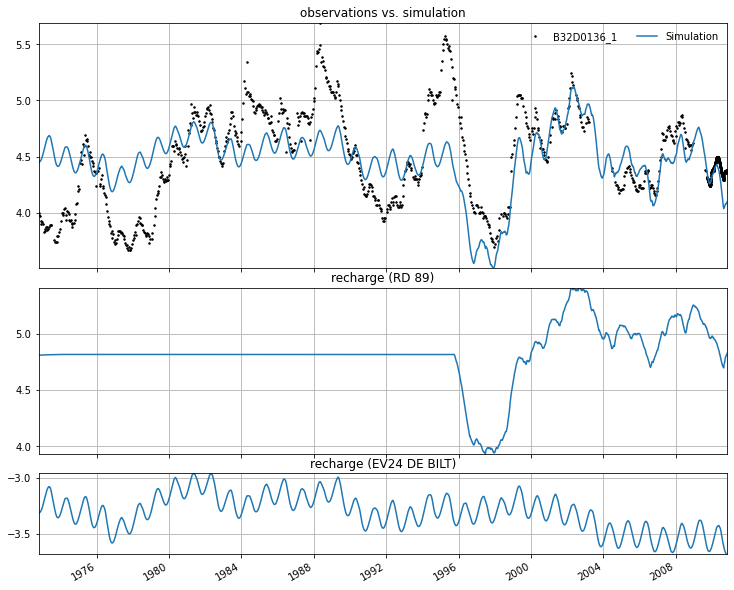

In [7]:
name = 'B32D0136_1'
ml = store.get_models(name)
ml.plots.decomposition()

## Get some statistics / parameters of all models
Make a table with some statistics of the models

In [8]:
store.get_statistics(['evp','aic'])

,evp,aic
B32D0136_1,29.762953,2.496356
B33A0113_1,28.757829,-1.418251
B58C0698_1,77.619494,6.737026


Make a table with some parameters of the models

In [9]:
store.get_parameters(['recharge_A','constant_d','noise_alpha'])

,recharge_A,constant_d,noise_alpha
B32D0136_1,2091.732802,2.952675,1737.767827
B33A0113_1,1957.706109,27.664519,4994.447588
B58C0698_1,518.498341,28.340849,76.343982


#### Exercise 4 <a name="ex4"></a>
Get the EVP from the models in your pastastore from exercise 3. What do you think?

<a href="#ans4">Answer Exercise 4</a>

#### Exercise 5 <a name="ex5"></a>

Improve the models in your pastastore from exercise 4 by:
- replacing the precipitation from Akkrum with measurements from IJsselstein. Use this website to obtain the data https://www.knmi.nl/nederland-nu/klimatologie/monv/reeksen. 
- replacing the evaporation from De Bilt with the evaporation from Arcen using this website https://www.knmi.nl/nederland-nu/klimatologie/daggegevens. 

Does this improve the EVP? Plot the results of model B52D0502_1, what do you see?

<a href="#ans5">Answer Exercise 5</a>

#### Exercise 6 <a name="ex6"></a>
There are no evaporation measurements at Arcen before 1991. Change the calibration period of the models using tmin in such a way that a more realistic model is created.

<a href="#ans6">Answer Exercise 6</a>

#### Exercise 7 <a name="ex7"></a>
Add a step trend to the models in january 2010. Solve the models and explore the results. What happens?

<a href="#ans7">Answer Exercise 7</a>

## Saving and reading pastastores
We can save an entire pastastore, with all its series and models, to a file.

In [10]:
store.to_zip('pastasstore.zip', overwrite=True)

C:\Anaconda3\lib\site-packages\pastastore\store.py:624: UserWarning: Overwriting file 'pastasstore.zip'


ValueError: DataFrame index must be unique for orient='columns'.

Later we can reload this pastastore again

In [ ]:
conn = pst.DictConnector("pastastore")
pst.PastaStore.from_zip('pastasstore.zip', conn)

Test if everything went ok by plotting the decomposition of B58C0698_1 again. This figure is exactly the same as before.

In [ ]:
name = 'B32D0136_1'
ml = store.get_models(name)
ml.plots.decomposition()


## Answers

#### <a href="#ex1">Answer exercise 1</a> <a name="ans1"></a>

Measurement point B52D0192_2 has the lowest filter. This can be seen in the column `Onderkant filter (cm t.o.v. NAP)` from the dataframe: `pr_q.oseries`. This is a hard question if you don't know Dutch (sorry!).

In [ ]:
# add the observations in all the files in the data-directory that end with _1.csv
conn2 = pst.DictConnector("data_nb4")
store2 = pst.PastaStore("data_nb4", conn2)

datapath2 = r'data/nb4/ex1'
files = [x for x in os.listdir(datapath2) if x.endswith('_1.csv')]
for file in files:
    fname = os.path.join(datapath2,file)
    series = ps.read_dino(fname)
    store2.add_oseries(series.series_original, name=series.name, metadata=series.metadata)
    
# show the contents of pr.oseries
store2.oseries

#### <a href="#ex2">Answer exercise 2</a> <a name="ans2"></a>

In [ ]:
datapath2 = r'data/nb4'

# add evaporation
fname = os.path.join(datapath,'KNMI_Bilt.txt')
series = ps.read_knmi(fname, variables='EV24')
store2.add_stress(series.series_original, name=series.name, kind='evap', metadata=series.metadata)

# add precipitatio
fname = os.path.join(datapath,'KNMI_Akkrum.txt')
series = ps.read_knmi(fname, variables='RD')
store2.add_stress(series.series_original, name=series.name, kind='prec', metadata=series.metadata)


# show the contents of pr.stresses
store2.stresses

#### <a href="#ex3">Answer exercise 3</a> <a name="ans3"></a>

In [ ]:
# alternative with a for-loop
for name in store2.oseries.index:
    ml = store2.create_model(name, add_recharge=True)
    ml.solve(report=False)
    store2.add_model(ml)

#### <a href="#ex4">Answer exercise 4</a> <a name="ans4"></a>

See the explained variance (evp) in the cell below. The evp is rather low. In general people use an evp value of more than 70-80% for a reasonable fit.

In [ ]:
store2.get_statistics(['evp'])

#### <a href="#ex5">Answer exercise 5</a> <a name="ans5"></a>

The evaporation time series of IJsselstein has no values before 1991 and therefore the model of B52D0502_1 and others have a poor fit/low evp. 

In [ ]:
# add evaporation
fname = os.path.join(datapath,'etmgeg_391.txt')
series = ps.read_knmi(fname, variables='EV24')
store2.add_stress(series.series_original, name=series.name, kind='evap', metadata=series.metadata)

# add precipitation
fname = os.path.join(datapath,'neerslaggeg_IJSSELSTEYN-L_913.txt')
series = ps.read_knmi(fname, variables='RD')
store2.add_stress(series.series_original, name=series.name, kind='prec', metadata=series.metadata)

# delete existing stresses
store2.del_stress('EV24 DE BILT')
store2.del_stress('RD 89')

# create and solve the models
for name in store2.oseries.index:
    ml = store2.create_model(name, add_recharge=True)
    ml.solve(report=False)
    store2.add_model(ml, overwrite=True)
    
# get the statistics
print(store2.get_statistics(['evp']))

# results of individual model
name = 'B52D0502_1'
ml = store2.get_models(name)
ml.plots.decomposition();

#### <a href="#ex6">Answer exercise 6</a> <a name="ans6"></a>

In [ ]:
for name in store2.oseries.index:
    ml = store2.create_model(name, add_recharge=True)
    ml.solve(tmin='1993', report=False)
    store2.add_model(ml, overwrite=True)
    
print(store2.get_statistics(['evp']))

# results of individual model
name = 'B52D0502_1'
ml = store2.get_models(name)
ml.plots.decomposition();

#### <a href="#ex7">Answer exercise 7</a> <a name="ans7"></a>

There seems to be little effect of the steptrend on the model results

In [ ]:
sm = ps.stressmodels.StepModel('2010', name='step', up=True)
sm2 = ps.stressmodels.StepModel('2013', name='step2', up=True)

for name in store2.oseries.index:
    ml = store2.create_model(name, add_recharge=True)
    ml.add_stressmodel(sm)
    #ml.add_stressmodel(sm2)
    ml.solve(tmin='1993', report=False)
    store2.add_model(ml, overwrite=True)
    
print(store2.get_statistics(['evp']))

# results of individual model
name = 'B52D0502_1'
ml = store2.get_models(name)
ml.plots.decomposition();